In [2]:
% pwd
import pdb
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

layer_names = ['conv1/7x7_s2', 'pool1/2x2_s2', 'conv2/3x3_s1', 'pool2/2x2_s2', 'conv3/1x1_s1', 'conv4/3x3_s1', 'conv5/1x1_s1','conv6/3x3_s1',   
'pool3/2x2_s2', 'conv7/1x1_s1', 'conv8/3x3_s1', 'conv9/1x1_s1', 'conv10/3x3_s1','conv11/1x1_s1','conv12/3x3_s1', 'conv13/1x1_s1','conv14/3x3_s1',  
'conv15/1x1_s1','conv16/3x3_s1','pool4/2x2_s2', 'conv17/1x1_s1','conv18/3x3_s1','conv19/1x1_s1','conv20/3x3_s1',
'conv21/3x3_s1','conv22/3x3_s2', 'conv23/3x3_s1', 'conv24/3x3_s1',   'dense1','dropout','dense2']

voc_name = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair',
             'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
             'sheep', 'sofa', 'train', 'tvmonitor']

In [3]:
#THEANO_FLAGS='floatX=float32,device=gpu0,lib.cnmem=1'
import theano
import theano.tensor as T

#print (theano.sandbox.cuda.device_properties(0))

In [4]:
#%load YOLO_network.py

#net = build_network()

In [5]:
import io
import skimage.transform
import matplotlib.pyplot as plt

%matplotlib inline

import urllib

index = urllib.urlopen('http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html').read()
image_urls = index.split('<br>')

np.random.seed(23)
np.random.shuffle(image_urls)
#image_urls = image_urls[:5]
image_urls = image_urls[:5]

def prep_image(url):
    ext = url.split('.')[-1]
    im = plt.imread(io.BytesIO(urllib.urlopen(url).read()), ext)
    # Resize so smallest dim = 448, preserving aspect ratio
    h, w, c = im.shape   
    
    im = skimage.transform.resize(im, (448, 448), preserve_range=True)
#     if h < w:
#         im = skimage.transform.resize(im, (448, w*448/h), preserve_range=True)
#     else:
#         im = skimage.transform.resize(im, (h*448/w, 448), preserve_range=True)

    # Central crop to 448x448
    h, w, c = im.shape
    im = im[h//2-224:h//2+224, w//2-224:w//2+224]
    
    rawim = np.copy(im).astype('uint8')
       
    im = im/255 
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]  ### chck if this is necessry

    return rawim, floatX(im[np.newaxis])


def prep_image_from_name(name, ext):
    im = plt.imread(name, ext)
    # Resize so smallest dim = 448, preserving aspect ratio
    h, w, c = im.shape  
    im = skimage.transform.resize(im, (448, 448), preserve_range=True)
    
    rawim = np.copy(im).astype('uint8')
       
    im = im/255 
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :] 

    return rawim, floatX(im[np.newaxis])


def old_prep_image_from_name(name, ext):
    im = plt.imread(name, ext)
    # Resize so smallest dim = 448, preserving aspect ratio
    h, w, _ = im.shape  
    pdb.set_trace()
    if h < w:
        im = skimage.transform.resize(im, (448, w*448/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*448/w, 448), preserve_range=True)

    # Central crop to 448x448
    h, w, c = im.shape
    im = im[h//2-224:h//2+224, w//2-224:w//2+224]
    
    rawim = np.copy(im).astype('uint8')
       
    im = im/255 
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :] 

    return rawim, floatX(im[np.newaxis])

In [6]:
def convert_YOLO_det(predictions, classes, num, thresh, side, square, only_objectness):
    per_grid_params = num*5 + classes   
    all_grids = side * side
    
    my_boxes_list = []    
    label_list = []
        
    probs = np.ndarray((all_grids * num, classes), dtype='float32')
   
    box_num = 0       
    for i in range(all_grids):             
        row = i / side
        col = i % side
                
        for n in range(num):
            index = i*num + n
            p_index = all_grids*classes + i*num + n
            scale = predictions[p_index][0]
                                                 
            box_index = all_grids*(classes + num) + (i*num + n) * 4
            
            w = pow(predictions[box_index + 2][0], 2) if (square == 1) else predictions[box_index + 2][0]
            h = pow(predictions[box_index + 3][0], 2) if (square == 1) else predictions[box_index + 3][0]
            
            my_boxes_list.append({"cx": (predictions[box_index + 0][0] + col) / side , 
                                  "cy": (predictions[box_index + 1][0] + row) / side ,
                                  "w" : w,
                                  "h" : h          
                                  }
                                )
            
            for j in range (classes):
                class_index = i*classes
                prob = scale*predictions[class_index + j][0]               
                prob = prob if (prob > thresh) else 0
                                                
                probs[index][j] = prob
            
            if (only_objectness):
                probs[index][0] = scale;
    
    return my_boxes_list, probs


def draw_detection_bbox(all_grids, probs, boxes, classes, num, w, h, thresh):
    draw_box_list = []
    
    for grid_idx in range(all_grids):        
        arg_array = np.argsort(probs[grid_idx])        
        category = arg_array[-1]               
        prob = probs[grid_idx][category]

        if (prob > thresh):
            box = boxes[grid_idx]  

            left =  (box['cx'] - box['w'] / 2.) * w
            right = (box['cx'] + box['w'] / 2.) * w
            top =   (box['cy'] - box['h'] / 2.) * h
            bot =   (box['cy'] + box['h'] / 2.) * h

            if (left  < 0):
                left = 0
            if ( right > w - 1):
                right = w - 1
            if (top < 0):
                top = 0
            if ( bot > h - 1):
                bot = h -1

            draw_box_list.append({"left": left, 
                             "top":  top,
                             "right" : right,
                             "bottom" : bot,
                             "confidence" : prob,
                             "category" : category
                             }
                            )
    
    return draw_box_list


In [7]:
import pickle
with open('YOLO_weights.pkl', 'rb') as f:    
    net = pickle.load(f)
    
import lasagne
from lasagne.utils import floatX 


def build_YT_net(net, input_var = None):
    import lasagne
    from lasagne.layers import DropoutLayer
    from lasagne.layers import InputLayer
    from lasagne.layers import DenseLayer
    from lasagne.nonlinearities import LeakyRectify
    #from lasagne.layers import LocalResponseNormalization2DLayer as LRNLayer
    from lasagne.nonlinearities import softmax, linear
    
    net_YOLO_YT = {}
    tshape = lasagne.layers.get_output_shape(net['dense1'] , input_shapes=None)    
    #net_YOLO_YT['input'] = InputLayer(shape = (tshape))      
    #net_YOLO_YT['input']  = InputLayer(shape=(tshape), input_var=T.matrix('inputs'))
    net_YOLO_YT['input'] = lasagne.layers.InputLayer(shape=(None, 4096), input_var=input_var)
    
    net_YOLO_YT['dropout'] = DropoutLayer(net_YOLO_YT['input'], p=0.5)
    net_YOLO_YT['dense2'] = DenseLayer(net_YOLO_YT['dropout'], num_units=1470, nonlinearity=linear)

    layer = net['dense2']
    W = layer.W.get_value()
    b = layer.b.get_value()                            

    net_YOLO_YT['dense2'].W.set_value(W)  
    net_YOLO_YT['dense2'].b.set_value(b) 
    
    net_YOLO_YT['output']= net_YOLO_YT['dense2']
    
    return net_YOLO_YT

bad url: http://www.tmk.com/tiger/6F5S5684-l.jpg


/home/subarna/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


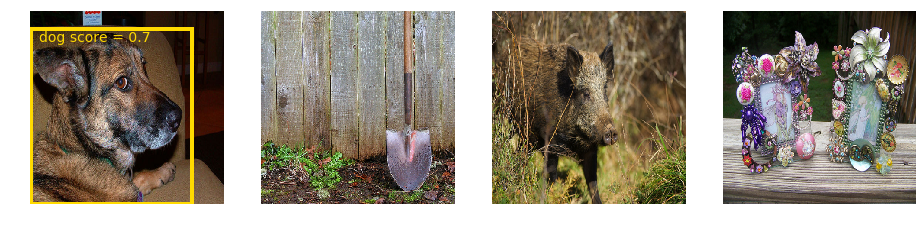

In [8]:
import pdb

from pprint import pprint

input_var = T.fmatrix('inputs')
target_var = T.fmatrix('targets')
weight_var = T.fmatrix('masks')

net_YOLO_YT = build_YT_net(net, input_var)

colormap = plt.cm.gist_ncar
colors = [colormap(j) for j in np.linspace(0, 1, 20)]
draw_box_list = []

enable_subplot = 1

YOLO_yt = 1

img_num = 0
for url in image_urls:
    square = 0    
    classes = 20
    num = 2
    thresh = 0.2
    side = 7
    all_grids = side * side
    
    try:
        rawim, im = prep_image(url)
        h, w, c = rawim.shape  
        
        if (YOLO_yt == 1):
            #dense1, direct_output = lasagne.layers.get_output([net['dense1'], net['dense2']], im, deterministic=True )
            dense1 = lasagne.layers.get_output(net['dense1'], im, deterministic=True )
            prob = np.array(lasagne.layers.get_output(net_YOLO_YT['dense2'], dense1, deterministic=True).eval())
            prob = np.transpose(prob)  
        else:            
            prob = np.array(lasagne.layers.get_output(net['output_layer'], im, deterministic=True).eval())
            prob = np.transpose(prob) 
        
        #pprint (vars(net['dense2']))        
        #pdb.set_trace()
          
        boxes, probs = convert_YOLO_det(prob, classes, num, thresh, side, square, 0)
        
        # nms
        # do sorting on areas and select the best overlapping one        
        draw_box_list = draw_detection_bbox(all_grids*2, probs, boxes, classes, num, w, h, thresh)  
        
        if(enable_subplot != 1):
            plt.figure()  
            plt.imshow(rawim.astype('uint8'))  
        else:            
            if(img_num %5 == 0): # new figure after every 5 images
                plt.figure(figsize=(20,20))            
                plt.subplot(1,5,1)        
            if(img_num %5 == 1):
                plt.subplot(1,5,2)
            elif(img_num %5 == 2):
                plt.subplot(1,5,3)
            elif(img_num %5 == 3):
                plt.subplot(1,5,4)
            elif(img_num %5 == 4):
                plt.subplot(1,5,5)
            plt.imshow(rawim.astype('uint8'), interpolation='nearest')  
        ######

        
        for box in draw_box_list:
            x = box['left']
            y = box['top']
            w = box['right'] - box['left']
            h = box['bottom'] - box['top']
            category = box['category'] 
            confidence = float("{0:.2f}".format(box['confidence']))

            plt.text(x+20, y+30, '{} score = {}'.format(voc_name[category], confidence), fontsize=14, color=colors[category])
            rect = plt.Rectangle((x,y), w, h, edgecolor=colors[category], facecolor="none", fill=False, linewidth = 4)
            plt.gca().add_patch(rect)
            plt.draw()
            
        plt.axis('off') 
        
        img_num += 1
        
                              
    except IOError:
        print('bad url: ' + url)

In [9]:
# ## allow fine-tuning only for the last = 29 (two = 28) dense layers' parameters
# l_num = 0
# for index, name in enumerate(layer_names): 
#     layer = net[name]    
    
#     if(l_num > 29 ) : # 28
#         break
    
#     if isinstance(layer, lasagne.layers.conv.Conv2DLayer) or isinstance(layer, lasagne.layers.dense.DenseLayer):  
#         layer.params[layer.b].remove('trainable')
#         layer.params[layer.W].remove('trainable')
        
#         l_num += 1

# #shape = lasagne.layers.get_output_shape(net['dense2'] , input_shapes=None)

In [10]:
 def write_features(data_pairs_list, training = True):
    ## write pkl file for all training data features and ground truths to easily load them during training or testing
    import pickle

    import skimage.transform
    import numpy as np
    import matplotlib.pyplot as plt
    import pdb

    %matplotlib inline
    
    fl_to_feat_map_index = []

    basic_path = 'Youtube/allImages/'
    X_features = np.ndarray( (len(data_pairs_list), 1470), dtype='float32')
    all_h = []
    all_w = []

    for i in range(len(data_pairs_list)):
        file_name = basic_path + data_pairs_list[i]['cat_type'] + '/' + data_pairs_list[i]['frame_num'] + '.jpg'    
        rawim, im = prep_image_from_name(file_name, 'jpg')
        h, w, c = rawim.shape  
          
        prob = np.array(lasagne.layers.get_output(net['output_layer'], im, deterministic=True).eval())        
        X_features[i,:] = prob   
        
        all_h.append(h)
        all_w.append(w)
    
    if(training):
        with open('X_train_feats.pkl', 'wb') as f:
            pickle.dump(X_features, f, -1)
    else:
        with open('X_test_feats.pkl', 'wb') as f:
            pickle.dump(X_features, f, -1)

##########################
def write_dense1_features(data_pairs_list, training = True):
    ## write pkl file for all training data features and ground truths to easily load them during training or testing
    import pickle

    #import skimage.transform
    import numpy as np
    import matplotlib.pyplot as plt
    #import pdb
    
    fl_to_feat_map_index = []

    basic_path = 'Youtube/allImages/'
    X_features = np.ndarray( (len(data_pairs_list), 4096), dtype='float32')
    
    ## make it faster
    #im_all = np.ndarray( (len(data_pairs_list), 3, 448, 448), dtype='float32')
    
    #all_h = []
    #all_w = []

    for i in range(len(data_pairs_list)):
        file_name = basic_path + data_pairs_list[i]['cat_type'] + '/' + data_pairs_list[i]['frame_num'] + '.jpg'
        #print file_name        
        rawim, im = prep_image_from_name(file_name, 'jpg')
        h, w, c = rawim.shape 
        fl_to_feat_map_index.append({file_name : i})
        
        prob = np.array(lasagne.layers.get_output(net['dense1'], im, deterministic=True).eval())
        X_features[i,:] = prob   
        
        #all_h.append(h)
        #all_w.append(w)
        
        ## make it faster
        #im_all[i,:,:,:] = im
        
    #X_features = np.array(lasagne.layers.get_output(net['dense1'], im_all, deterministic=True).eval())               
    ##########
    if(training):
        with open('X_train_dense1_feats.pkl', 'wb') as f:
            pickle.dump(X_features, f, -1)                
    else:
        with open('X_test_dense1_feats.pkl', 'wb') as f:
            pickle.dump(X_features, f, -1)

            
###########################
def det_features(data_pair_list, fl_to_featmap_index, batch, training = True):
    #import skimage.transform
    import numpy as np
    import pickle
    
    if(training):
        with open('X_train_feats.pkl', 'rb') as f:    ## X_train_feats.pkl
            X_feats = pickle.load(f)
    else:
         with open('X_test_feats.pkl', 'rb') as f:    ## X_train_feats.pkl
            X_feats = pickle.load(f)

    #import matplotlib.pyplot as plt
    #%matplotlib inline
       
    basic_path = 'Youtube/allImages/'    
    X_features = np.ndarray( (len(batch), 1470), dtype='float32')  #1470
    
    #batch_im = np.ndarray( (len(batch), 3, 448, 448), dtype='float32')    
    
    count = 0
    for i in batch:
        #file_name = basic_path + training_list[i]['cat_type'] + '/' + training_list[i]['frame_num'] + '.jpg'        
        ##print file_name                  
        #rawim, im = prep_image_from_name(file_name, 'jpg')    
        #h, w, c = rawim.shape
        #batch_im[count,:,:,:] = im
        
        #prob = np.array(lasagne.layers.get_output(net['output_layer'], im, deterministic=True).eval())
        #prob = np.transpose(prob)  
        #X_features[i,:] = np.transpose(prob) 
               
        ## file name to feature map index through dictionary        
        key_name = data_pair_list[i]['GT_im_name']                
        ft_idx = fl_to_featmap_index[key_name]                                               
        X_features[count, :] = X_feats[ft_idx, :]
        
        count +=1
    
    ## take output on minibatch   
    #prob = np.array(lasagne.layers.get_output(net['output_layer'], batch_im, deterministic=True).eval())
    #prob = np.transpose(prob)  
    #X_features = np.transpose(prob)  
            
    return X_features

################################
def det_detection_truth(featmap_index, data_list, batch, training = True, val = False ):
    import pickle
    classes = 20
    coord = 4
    side = 7
    all_grids = side * side
    elems_per_grid = 1+coord+classes
    
    if(training):
        with open('Y_train_labels.pkl', 'rb') as f:    ## X_train_labels.pkl
            Y_labels = pickle.load(f)   #print Y_labels
    elif (val):
        with open('Y_train_labels.pkl', 'rb') as f:    ## X_train_labels.pkl
            Y_labels = pickle.load(f)   #print Y_labels
    else:
        with open('Y_test_labels.pkl', 'rb') as f:    ## X_train_labels.pkl
            Y_labels = pickle.load(f)   #print Y_labels
        
    Y_mb = np.ndarray( (len(batch), (all_grids*elems_per_grid)), dtype='float32')  #1470
    
    count = 0
    for i in batch:               
        ## file name to feature map index through dictionary        
        key_name = data_list[i]['GT_im_name']                
        ft_idx = featmap_index[key_name]                                               
        Y_mb[count, :] = Y_labels[ft_idx, :]   #print np.sum(Y_train_mb[count])
                
        count +=1

    return Y_mb


###################################################
def det_features_from_dense1(current_list, fl_to_featmap_index, batch, training = True):
    #import skimage.transform
    import numpy as np
    import pickle
    
    import pdb
    
    if(training):
        with open('X_train_dense1_feats.pkl', 'rb') as f:    
            X_feats = pickle.load(f)
    else:
        with open('X_test_dense1_feats.pkl', 'rb') as f:    
            X_feats = pickle.load(f)

    #import matplotlib.pyplot as plt
    #%matplotlib inline
       
    basic_path = 'Youtube/allImages/'    
    X_features_mb = np.ndarray( (len(batch), 4096), dtype='float32')  
    #batch_im = np.ndarray( (len(batch), 3, 448, 448), dtype='float32')      
    
    count = 0
    for i in batch:               
        ## file name to feature map index through dictionary        
        key_name = current_list[i]['GT_im_name']                
        ft_idx = fl_to_featmap_index[key_name]                                               
        X_features_mb[count, :] = X_feats[ft_idx, :]
        
        count +=1
    
    return X_features_mb

In [11]:
import theano
import theano.tensor as T
import lasagne

np.random.seed(42)

In [12]:
def calc_iou(boxa, boxb):
    si = 0
    dx = min([boxa[2], boxb[2]]) - max([boxa[0],boxb[0]])
    dy = min([boxa[3], boxb[3]]) - max([boxa[1],boxb[1]])
    
    if (dx > 0 ) & (dy > 0): 
        si = dx * dy              
    
    sa = boxa[4]
    sb = boxb[4]
    su = sa + sb - si
    iou = si/su
    
    rmse = np.sqrt( (boxa[0]-boxb[0])**2 + 
                   (boxa[1]-boxb[1])**2 +
                   (boxa[2]-boxb[2])**2 +
                   (boxa[3]-boxb[3])**2
                  )
    
    return iou, rmse

###########################################
def detect_accuracy(x_pred_mb, y_label_mb, my_net):
    import pdb
    
    #x_pred_mb = np.array(lasagne.layers.get_output(net_YOLO_YT['dense2'], x_pred_mb, deterministic=True).eval()) 
    x_pred_mb = np.array(lasagne.layers.get_output(my_net['dense2'], x_pred_mb, deterministic=True).eval()) 
    
    side = 7
    classes = 20
    coord = 4
    all_grids = side * side
    nb = 2
    conf_thresh = 0.1
    iou_det_thresh = 0.5
        
    is_obj = np.zeros((y_label_mb.shape[0], all_grids), dtype='int')
    f_boxes = np.zeros((coord + 1), dtype='float32')
    s_boxes = np.zeros((coord + 1), dtype='float32')
    
    det_cases = np.zeros((y_label_mb.shape[0], 20), dtype='int')
    gt_cases = np.zeros((y_label_mb.shape[0], 20), dtype='int')
    
    factor = 400 #500 #400 
        
    for k in range(y_label_mb.shape[0]):
        c_gt_nums = 0        
        gt_boxes = []
        
        det_nums = 0
        det_boxes = []
        for i in range(0, all_grids):
            truth_index = i * (1 + coord + classes)
            is_obj[k,i] = y_label_mb[k,truth_index] 
            class_conditional_index = np.arange(i*classes, (i+1)*classes )
            from_index_cls = np.arange(truth_index+1, truth_index+1+classes)
            
            row = i / side
            col = i % side
            
            t_coord = truth_index+1+classes
            from_index  = np.arange(t_coord, t_coord+coord )        
            ##calc best IOU for determining "responsible" BB in every grid                                    
            if(is_obj[k,i]):
                c_gt_nums += 1
                ## GT category for this grid
                arg_array = np.argsort(y_label_mb[k,from_index_cls])  
                gt_cat = arg_array[-1]
                gt_cases[k, gt_cat] += 1

                gt_box = [ factor*(y_label_mb[k,from_index[0]] + col)/side,
                      factor*(y_label_mb[k,from_index[1]] + row) /side,
                      factor* y_label_mb[k,from_index[2]]*y_label_mb[k,from_index[2]] *factor,
                      factor* y_label_mb[k,from_index[3]]*y_label_mb[k,from_index[3]] *factor,
                      gt_cat    
                     ]
                gt_box = [gt_box[0] - gt_box[2]/2,
                      gt_box[1] - gt_box[3]/2,
                      gt_box[0] + gt_box[2]/2,
                      gt_box[1] + gt_box[3]/2,
                      gt_box[2] * gt_box[3],
                      gt_cat    
                     ]                 
                gt_boxes.append(gt_box)
                                
                
            test_cat = np.argmax(x_pred_mb[k,class_conditional_index]) 
            cat_conf = np.amax(x_pred_mb[k,class_conditional_index])   #x_pred_mb[k,test_cat]
                                            
            bb_idx = 0            
            sc = all_grids*classes + i*nb 
            max_val = x_pred_mb[k, sc]               
            if(x_pred_mb[k, sc+1]  > max_val):
                max_val = x_pred_mb[k, sc+1]
                bb_idx = 1
               
            if ( max_val * cat_conf >  conf_thresh):
                ## debug : correct confidence score
                #print max_val * cat_conf

                s = all_grids*classes + nb*all_grids + i*nb*coord + bb_idx*coord
                coord_index = np.arange( s, s+coord )  

                det_box = [ factor*(x_pred_mb[k,coord_index[0]] + col)/side,
                      factor*(x_pred_mb[k,coord_index[1]] + row)/ side,
                      factor*x_pred_mb[k,coord_index[2]]*x_pred_mb[k,coord_index[2]]*factor,
                      factor*x_pred_mb[k,coord_index[3]]*x_pred_mb[k,coord_index[3]]*factor,
                       test_cat
                     ]
                det_box = [det_box[0] - det_box[2]/2,
                      det_box[1] - det_box[3]/2,
                      det_box[0] + det_box[2]/2,
                      det_box[1] + det_box[3]/2,
                      det_box[2] * det_box[3],
                      test_cat    
                     ]                 
                det_boxes.append(det_box) 
        
        # end of all grids processing for one example        
        det_cases[k,:] = detections_eval(gt_boxes, det_boxes, iou_det_thresh, k) 
        
    # end all the mini-batch processing    
    return np.sum(det_cases, axis=0) , np.sum(gt_cases, axis=0) 
    #return det_cases, gt_cases 




def detections_eval(boxa, boxb, iou_det_thresh, k):
    gt_num = len(boxa)
    det_num = len(boxb)
    det_cases_curr = np.zeros((1,20), dtype = 'int')
    gt_flags = np.zeros(gt_num, dtype='int')
    
    for i in range(gt_num):
        gt_box = boxa[i]        
       
        for j in range(det_num):
            test_box = boxb[j]
            
            si = 0
            dx = min([gt_box[2], test_box[2]]) - max( [gt_box[0], test_box[0]] )
            dy = min([gt_box[3], test_box[3]]) - max( [gt_box[1], test_box[1]] )
            
            if (dx > 0 ) & (dy > 0):
                si = dx * dy

            sa = gt_box[4]
            sb = test_box[4]
            su = sa + sb - si
            iou = si/su
            
            if(gt_flags[i] == 0):
                if( test_box[5] == gt_box[5]): # same category
                    #print 'matched category' 
                    #print iou                
                    if( (iou > iou_det_thresh)):
                        #print iou
                        det_cases_curr[0, test_box[5]] += 1                    
                        gt_flags[i] = 1
    
    #print np.transpose(det_cases)        
    return det_cases_curr


In [13]:
# input_var = T.fmatrix('inputs')
# target_var = T.fmatrix('targets')
# weight_var = T.fmatrix('masks')

# net_YOLO_YT = build_YT_net(net, input_var)

In [14]:
def get_data_pairs_list(training = True ):
    import scipy.io
    import pdb
    import os
    
    data_pairs_list = []    
    featmap_index = {}  # as a dictionary so that can access by key
    
    count = 0 
    cat = 0
    base_gt_folder = 'Youtube/GroundTruth'
    for cat_name in voc_name:
        cat_folder = base_gt_folder + '/' + cat_name

        if os.path.isdir(cat_folder) :            
            if(training):
                gt_file_name = cat_folder + '/bb_gtTraining_' + cat_name +'.mat'  
                gt = scipy.io.loadmat(gt_file_name, struct_as_record=True)['bb_gtTraining'] 
            else:
                gt_file_name = cat_folder + '/bb_gtTest_' + cat_name +'.mat'
                gt = scipy.io.loadmat(gt_file_name, struct_as_record=True)['bb_gtTest'] 
                                  
            im_names = gt['im']
            boxes = gt['boxes']
            
            
            for l in range(0, im_names.shape[1]):  # number of images in that category                            
                data_pairs_list.append( {"cat_type" : cat_name,
                                        "category_num": cat,
                                        "frame_num": im_names[0,l][0][-8:],
                                        "boxes_num": boxes[0,l].shape[0],
                                        "boxes_coord": boxes[0,l],
                                        "GT_im_name":str(im_names[0,l][0])
                                         }
                                      ) 
                key_name = str(im_names[0,l][0])
                
                featmap_index.update({key_name: count})     #featmap_index.append({key_name: count})                 
                count += 1
                
        cat += 1        
            
    return data_pairs_list, featmap_index


def iterate_detection_minibatches(input_batch, batch_size, shuffle=False):
    import numpy as np
       
    if shuffle:
        indices = np.arange(len(input_batch))
        np.random.shuffle(indices)
        
    for start_idx in range(0, len(input_batch) - batch_size + 1, batch_size ):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
            
        else:
            excerpt = slice(start_idx, start_idx + batch_size)    
            
        
        yield input_batch[excerpt]
       
               

In [24]:
def write_labels(entry, featmap_index, training = True):    
    import pdb    
    import numpy as np
    
    classes = 20
    side = 7
    all_grids = side * side
    
    my_boxes_list = []    
    label_list = []
    elems_per_grid = 1+ 4 + classes
    
    Y_labels = np.ndarray( ( len(entry), all_grids*elems_per_grid), dtype='float32')    
    truth_vec = np.zeros( (1, (all_grids*elems_per_grid)), dtype='float32') 
    
    if(training):
        base_lb_folder = 'Youtube/labels/'
    else:
        base_lb_folder = 'Youtube/test_labels/'
    
    for img_nb in range(len(entry)):
        truth_vec.fill(0)
        category = entry[img_nb]['category_num']  
        
        ## file name to feature map index through dictionary        
        key_name = entry[img_nb]['GT_im_name']                
        ft_idx = featmap_index[key_name]  
               
        tmp = "%06d.txt" % (ft_idx + 1)
        label_file = base_lb_folder + tmp
         
        with open(label_file) as f:
            for line in f:               #lines = f.read().split('\n')                           
                elems = line.split(' ')        
                class_id = int(elems[0]) - 1
              
                cx = float(elems[1])
                cy = float(elems[2])
                
                col = float(cx) * side                                           
                col = int(np.clip(col, 0, side - 1))            
                row = float(cy) * side
                row = int(np.clip(row, 0, side - 1))
                                                           
                index = row * side * elems_per_grid + col*elems_per_grid                 #print index
                truth_vec[0,index] = 1
                                               
                index += 1
                truth_vec[0,index + (class_id)] = 1
                
                cx = cx*side - col
                cy = cy*side - row
                
                w = float(elems[3])
                h = float(elems[4])
                w = np.sqrt(w)
                h = np.sqrt(h)
                                
                index += classes
                truth_vec[0,index]     = cx
                truth_vec[0,index + 1] = cy
                truth_vec[0,index + 2] = w
                truth_vec[0,index + 3] = h
                
        Y_labels[img_nb,:] = truth_vec
        
        
    if(training):
        with open('Y_train_labels.pkl', 'wb') as f:    
            pickle.dump(Y_labels,f, -1)
    else:
        with open('Y_test_labels.pkl', 'wb') as f:    
            pickle.dump(Y_labels,f, -1)
             
    
    return Y_labels


##########################################################################
def create_compatible_label_masks_1(x_pred_mb, y_label_mb, val):      
    val = True
#     if(val == True):
#         x_pred_mb = np.matrix(lasagne.layers.get_output(net_YOLO_YT['dense2'], x_pred_dense1_mb, deterministic=True).eval()) 
#     else:
#         x_pred_mb = np.matrix(lasagne.layers.get_output(net_YOLO_YT['dense2'], x_pred_dense1_mb).eval()) 
    
    in_shape = x_pred_mb.shape     
    propagated_target = np.zeros((y_label_mb.shape[0], 1470), dtype='float32') ## prediction size = 1470
    wgt_mask          = np.zeros( (in_shape), dtype='float32') ## prediction size = 1470
    
    l_coord = 5.
    l_noobj = 0.5
    l_default = 1.
    side = 7
    classes = 20
    coord = 4
    all_grids = side * side
    nb = 2
    rmse_thresh = 20
    
    f_boxes = np.zeros((coord + 1), dtype='float32')
    s_boxes = np.zeros((coord + 1), dtype='float32')
    factor = 400 #
     
    ## arrangement order
    ## class conditionals for all grids, scores for all BBs in all grids, coords of all BBs in all grids       
    for i in range(0, all_grids):
        row = i / side
        col = i % side
        
        s = all_grids*classes + nb*all_grids + i*nb*coord 
        coord_index = np.arange( s, s+coord )    
        sc = all_grids*classes + i*nb ## score of first BB for that grid
        
        truth_index = i * (1 + coord + classes)        
        class_conditional_index = np.arange(i*classes, (i+1)*classes )
        from_index_cls = np.arange(truth_index+1, truth_index+1+classes)

        t_coord = truth_index+1+classes
        from_index_coord  = np.arange(t_coord, t_coord+coord )  
        
        for k in range(y_label_mb.shape[0]):             
            if (y_label_mb[k,truth_index] == 0):
                wgt_mask[k, classes*all_grids + i*nb + 0] = l_noobj  # weights for confidence if object not present 
                wgt_mask[k, classes*all_grids + i*nb + 1] = l_noobj  # weights for confidence if object not present 
            else:
                wgt_mask[k, classes*all_grids + i*nb + 0] = l_default  # weights for confidence if object present 
                wgt_mask[k, classes*all_grids + i*nb + 1] = l_default  # weights for confidence if object present                 
                wgt_mask[k,class_conditional_index] = l_default  ## non-zero weights for class conditionals only if objects present
            
            propagated_target[k,class_conditional_index] = y_label_mb[k,from_index_cls]  ## class conditionals
                        
            ### masks will be non-zero if obj_present in that grid; otherwise no effect on cost
            if (y_label_mb[k,truth_index] == 1):                 
                gt_box = [ factor *(y_label_mb[k,from_index_coord[0]]+ col )/ side,
                      factor *(y_label_mb[k,from_index_coord[1]] + row)/side,
                      factor * y_label_mb[k,from_index_coord[2]]*y_label_mb[k,from_index_coord[2]] *factor,
                      factor * y_label_mb[k,from_index_coord[3]]*y_label_mb[k,from_index_coord[3]] *factor
                     ]
                gt_box = [gt_box[0] - gt_box[2]/2,
                      gt_box[1] - gt_box[3]/2,
                      gt_box[0] + gt_box[2]/2,
                      gt_box[1] + gt_box[3]/2,
                      gt_box[2] * gt_box[3]
                     ]
            
                ##calc best IOU for determining "responsible" BB in every grid 
                for j in range(0,nb):
                    s = all_grids*classes + nb*all_grids + i*nb*coord + j*coord
                    coord_index = np.arange( s, s+coord )                       
                    sc = all_grids*classes + i*nb + j                     

                    propagated_target[k,coord_index] = y_label_mb[k,from_index_coord]  ## Box coordinates

                    sc = all_grids*classes + i*nb + j
                    if (y_label_mb[k,truth_index] != 0):  ## is_obj True 
                        propagated_target[k,sc] = 1   #object present so, gt has full confidence (1)
                        if j == 0:
                            f_boxes = [ factor *(x_pred_mb[k,coord_index[0]] + col)/side,
                                      factor *(x_pred_mb[k,coord_index[1]]+row)/side,
                                      factor *x_pred_mb[k,coord_index[2]]*x_pred_mb[k,coord_index[2]] *factor,
                                      factor *x_pred_mb[k,coord_index[3]]*x_pred_mb[k,coord_index[3]] *factor                         
                                     ]
                            f_boxes = [ f_boxes[0] - f_boxes[2]/2,
                                      f_boxes[1] - f_boxes[3]/2,
                                      f_boxes[0] + f_boxes[2]/2,
                                      f_boxes[1] + f_boxes[3]/2,
                                      f_boxes[2] * f_boxes[3]
                                     ]
                        else:
                            s_boxes = [ factor *(x_pred_mb[k,coord_index[0]] + col)/side,
                                      factor *(x_pred_mb[k,coord_index[1]] + row)/side,
                                      factor *x_pred_mb[k,coord_index[2]]*x_pred_mb[k,coord_index[2]]*factor,
                                      factor *x_pred_mb[k,coord_index[3]]*x_pred_mb[k,coord_index[3]]*factor
                                     ]
                            s_boxes = [ s_boxes[0] - s_boxes[2]/2,
                                      s_boxes[1] - s_boxes[3]/2,
                                      s_boxes[0] + s_boxes[2]/2,
                                      s_boxes[1] + s_boxes[3]/2,
                                      s_boxes[2] * s_boxes[3]
                                     ] 
                iou_arr = []
                rmse_arr = []
                        
                ## which BB produces highest iou - set1 or set 2
                if (y_label_mb[k,truth_index] != 0):  ## is_obj True                 
                    iou1, rmse1 = calc_iou(gt_box, f_boxes)
                    iou2, rmse2 = calc_iou(gt_box, s_boxes)
                    iou_arr.append(iou1)
                    iou_arr.append(iou2)

                    rmse_arr.append(rmse1)
                    rmse_arr.append(rmse2)

                    iou_ind = np.argmax(iou_arr)
                    rmse_ind = np.argmin(rmse_arr)

                    if (iou_arr[iou_ind] > 0 ): 
                        bb_idx = iou_ind
                    elif (rmse_arr[rmse_ind] < rmse_thresh):
                        bb_idx = rmse_ind
                    else: 
                        # weights are already zero and continue
                        bb_idx = 0 ## default BB index for loss minimization if none of iou and rmse satisfied

                    #pdb.set_trace()                           
                    s = all_grids*classes + nb*all_grids + i*nb*coord + bb_idx*coord
                    coord_index = np.arange( s, s+coord )                       
                    wgt_mask[k,coord_index] = l_coord  # for localization in proper grid location with responsible BB

#                     sc = all_grids*classes + i*nb + bb_idx
#                     wgt_mask[k,sc] = l_default   #object present so, gt has full confidence (1)
    
                    ## enabling re-scoring
#                     nume = (iou_arr[bb_idx] - x_pred_mb[k,sc])**2
#                     denom = (propagated_target[k,sc] - x_pred_mb[k,sc])**2                    
#                     wgt_mask[k,sc] = l_default * (nume / denom)
                    #######
    
    
    ## incorporate this scale
    #los += pow(1-iou)**2
    
    #loss_matrix = (x_pred_mb - propagated_target)**2
    
    return propagated_target, wgt_mask  # loss_matrix 



####################################################
def create_compatible_label_masks(x_pred_dense1_mb, y_label_mb, val):  
    
    val = True
    if(val == True):
        x_pred_mb = np.matrix(lasagne.layers.get_output(net_YOLO_YT['dense2'], x_pred_dense1_mb, deterministic=True).eval()) 
    else:
        x_pred_mb = np.matrix(lasagne.layers.get_output(net_YOLO_YT['dense2'], x_pred_dense1_mb).eval()) 
    
    in_shape = x_pred_mb.shape     
    propagated_target = np.zeros((y_label_mb.shape[0], 1470), dtype='float32') ## prediction size = 1470
    wgt_mask          = np.zeros( (in_shape), dtype='float32') ## prediction size = 1470
    
    l_coord = 5.
    l_noobj = 0.5
    l_default = 1.
    side = 7
    classes = 20
    coord = 4
    all_grids = side * side
    nb = 2
    rmse_thresh = 20
    
    f_boxes = np.zeros((coord + 1), dtype='float32')
    s_boxes = np.zeros((coord + 1), dtype='float32')
    factor = 400 #
     
    ## arrangement order
    ## class conditionals for all grids, scores for all BBs in all grids, coords of all BBs in all grids       
    for i in range(0, all_grids):
        row = i / side
        col = i % side
        
        s = all_grids*classes + nb*all_grids + i*nb*coord 
        coord_index = np.arange( s, s+coord )    
        sc = all_grids*classes + i*nb ## score of first BB for that grid
        
        truth_index = i * (1 + coord + classes)        
        class_conditional_index = np.arange(i*classes, (i+1)*classes )
        from_index_cls = np.arange(truth_index+1, truth_index+1+classes)

        t_coord = truth_index+1+classes
        from_index_coord  = np.arange(t_coord, t_coord+coord )  
        
        for k in range(y_label_mb.shape[0]):             
            if (y_label_mb[k,truth_index] == 0):
                wgt_mask[k, classes*all_grids + i*nb + 0] = l_noobj  # weights for confidence if object not present 
                wgt_mask[k, classes*all_grids + i*nb + 1] = l_noobj  # weights for confidence if object not present 
            else:
                wgt_mask[k, classes*all_grids + i*nb + 0] = l_default  # weights for confidence if object present 
                wgt_mask[k, classes*all_grids + i*nb + 1] = l_default  # weights for confidence if object present                 
                wgt_mask[k,class_conditional_index] = l_default  ## non-zero weights for class conditionals only if objects present
            
            propagated_target[k,class_conditional_index] = y_label_mb[k,from_index_cls]  ## class conditionals
                        
            ### masks will be non-zero if obj_present in that grid; otherwise no effect on cost
            if (y_label_mb[k,truth_index] == 1):                 
                gt_box = [ factor *(y_label_mb[k,from_index_coord[0]]+ col )/ side,
                      factor *(y_label_mb[k,from_index_coord[1]] + row)/side,
                      factor * y_label_mb[k,from_index_coord[2]]*y_label_mb[k,from_index_coord[2]] *factor,
                      factor * y_label_mb[k,from_index_coord[3]]*y_label_mb[k,from_index_coord[3]] *factor
                     ]
                gt_box = [gt_box[0] - gt_box[2]/2,
                      gt_box[1] - gt_box[3]/2,
                      gt_box[0] + gt_box[2]/2,
                      gt_box[1] + gt_box[3]/2,
                      gt_box[2] * gt_box[3]
                     ]
            
                ##calc best IOU for determining "responsible" BB in every grid 
                for j in range(0,nb):
                    s = all_grids*classes + nb*all_grids + i*nb*coord + j*coord
                    coord_index = np.arange( s, s+coord )                       
                    sc = all_grids*classes + i*nb + j                     

                    propagated_target[k,coord_index] = y_label_mb[k,from_index_coord]  ## Box coordinates

                    sc = all_grids*classes + i*nb + j
                    if (y_label_mb[k,truth_index] != 0):  ## is_obj True 
                        propagated_target[k,sc] = 1   #object present so, gt has full confidence (1)
                        if j == 0:
                            f_boxes = [ factor *(x_pred_mb[k,coord_index[0]] + col)/side,
                                      factor *(x_pred_mb[k,coord_index[1]]+row)/side,
                                      factor *x_pred_mb[k,coord_index[2]]*x_pred_mb[k,coord_index[2]] *factor,
                                      factor *x_pred_mb[k,coord_index[3]]*x_pred_mb[k,coord_index[3]] *factor                         
                                     ]
                            f_boxes = [ f_boxes[0] - f_boxes[2]/2,
                                      f_boxes[1] - f_boxes[3]/2,
                                      f_boxes[0] + f_boxes[2]/2,
                                      f_boxes[1] + f_boxes[3]/2,
                                      f_boxes[2] * f_boxes[3]
                                     ]
                        else:
                            s_boxes = [ factor *(x_pred_mb[k,coord_index[0]] + col)/side,
                                      factor *(x_pred_mb[k,coord_index[1]] + row)/side,
                                      factor *x_pred_mb[k,coord_index[2]]*x_pred_mb[k,coord_index[2]]*factor,
                                      factor *x_pred_mb[k,coord_index[3]]*x_pred_mb[k,coord_index[3]]*factor
                                     ]
                            s_boxes = [ s_boxes[0] - s_boxes[2]/2,
                                      s_boxes[1] - s_boxes[3]/2,
                                      s_boxes[0] + s_boxes[2]/2,
                                      s_boxes[1] + s_boxes[3]/2,
                                      s_boxes[2] * s_boxes[3]
                                     ] 
                iou_arr = []
                rmse_arr = []
                        
                ## which BB produces highest iou - set1 or set 2
                if (y_label_mb[k,truth_index] != 0):  ## is_obj True                 
                    iou1, rmse1 = calc_iou(gt_box, f_boxes)
                    iou2, rmse2 = calc_iou(gt_box, s_boxes)
                    iou_arr.append(iou1)
                    iou_arr.append(iou2)

                    rmse_arr.append(rmse1)
                    rmse_arr.append(rmse2)

                    iou_ind = np.argmax(iou_arr)
                    rmse_ind = np.argmin(rmse_arr)

                    if (iou_arr[iou_ind] > 0 ): 
                        bb_idx = iou_ind
                    elif (rmse_arr[rmse_ind] < rmse_thresh):
                        bb_idx = rmse_ind
                    else: 
                        # weights are already zero and continue
                        bb_idx = 0 ## default BB index for loss minimization if none of iou and rmse satisfied

                    #pdb.set_trace()                           
                    s = all_grids*classes + nb*all_grids + i*nb*coord + bb_idx*coord
                    coord_index = np.arange( s, s+coord )                       
                    wgt_mask[k,coord_index] = l_coord  # for localization in proper grid location with responsible BB

#                     sc = all_grids*classes + i*nb + bb_idx
#                     wgt_mask[k,sc] = l_default   #object present so, gt has full confidence (1)
    
                    ## enabling re-scoring
#                     nume = (iou_arr[bb_idx] - x_pred_mb[k,sc])**2
#                     denom = (propagated_target[k,sc] - x_pred_mb[k,sc])**2                    
#                     wgt_mask[k,sc] = l_default * (nume / denom)
                    #######
    
    
    ## incorporate this scale
    #los += pow(1-iou)**2
    
    #loss_matrix = (x_pred_mb - propagated_target)**2
    
    return propagated_target, wgt_mask  # loss_matrix 



##############################################################
def create_compatible_label(y_label_mb):   
    #import pdb
    propagated_target = np.zeros((y_label_mb.shape[0], 1470), dtype='float32') ## prediction size = 1470
    
    side = 7
    classes = 20
    coord = 4
    all_grids = side * side
    nb = 2
    
    ## arrangement order
    ## class conditionals for all grids, scores for all BBs in all grids, coords of all BBs in all grids
    is_obj = np.zeros((y_label_mb.shape[0], all_grids), dtype='float32')
    
    for k in range(y_label_mb.shape[0]): 
        for i in range(all_grids):
            truth_index = i * (1 + coord + classes)
            is_obj[k,i] = y_label_mb[k,truth_index] 
            
            class_conditional_index = np.arange(i*classes, (i+1)*classes )
            from_index_cls = np.arange(truth_index+1, truth_index+1+classes)
            propagated_target[k,class_conditional_index] = y_label_mb[k,from_index_cls]  ## class conditionals

            t_coord = truth_index+1+classes
            from_index_coord  = np.arange(t_coord, t_coord+coord )        
                                    
            for j in range(0,nb):
                s = all_grids*classes + nb*all_grids + (i*nb + j)*coord 
                coord_index = np.arange( s, s+coord )                       
                propagated_target[k,coord_index] = y_label_mb[k,from_index_coord]  ## Box coordinates
                
                sc = all_grids*classes + i*nb + j
                if (is_obj[k,i] != 0):                    
                    propagated_target[k,sc] = 1   #object present so, gt has full confidence (1)

                        
    return propagated_target


###############################################
def create_weight_mask(x_pred_mb, y_label_mb):   
    
    x_pred_mb = np.matrix(lasagne.layers.get_output(net_YOLO_YT['dense2'], x_pred_mb, deterministic=True).eval())  
    in_shape = x_pred_mb.shape       
            
    l_coord = 5.
    l_noobj = 0.5
    l_default = 1.
    side = 7
    classes = 20
    coord = 4
    all_grids = side * side
    nb = 2
    rmse_thresh = 20
    
    wgt_mask          = np.ones( (in_shape), dtype='float32') ## prediction size = 1470
    is_obj = np.zeros((y_label_mb.shape[0], all_grids), dtype='float32')
                
    f_boxes = np.zeros((coord + 1), dtype='float32')
    s_boxes = np.zeros((coord + 1), dtype='float32')
    factor = 400
        
    for i in range(0, all_grids):
        row = i / side
        col = i % side
        
        s = all_grids*classes + nb*all_grids + i*nb*coord 
        coord_index = np.arange( s, s+coord )    
        sc = all_grids*classes + i*nb # for both the BBs, GT has already been propagated, so use first BB means corresponding BB
        
        ##calc best IOU for determining "responsible" BB in every grid 
        class_conditional_index = np.arange(i*classes, (i+1)*classes )
        
        for k in range(y_label_mb.shape[0]):             
            if (y_label_mb[k,sc] == 0):
                wgt_mask[k, classes*all_grids + i*nb + 0] = l_noobj  # weights for confidence if object not present 
                wgt_mask[k, classes*all_grids + i*nb + 1] = l_noobj  # weights for confidence if object not present 
            else:  
                wgt_mask[k,class_conditional_index] = l_default  ## non-zero weights for class conditionals only if objects present
            
            gt_box = [ factor*(y_label_mb[k,coord_index[0]]+ col )/ side,
                  factor*(y_label_mb[k,coord_index[1]] + row)/side,
                  factor* y_label_mb[k,coord_index[2]]*y_label_mb[k,coord_index[2]]*factor,
                  factor*y_label_mb[k,coord_index[3]]*y_label_mb[k,coord_index[3]]*factor
                 ]
            gt_box = [gt_box[0] - gt_box[2]/2,
                  gt_box[1] - gt_box[3]/2,
                  gt_box[2] + gt_box[2]/2,
                  gt_box[3] + gt_box[3]/2,
                  gt_box[2] * gt_box[3]
                 ]                  
            
            for j in range(0,nb):
                s = all_grids*classes + nb*all_grids + i*nb*coord + j*coord
                coord_index = np.arange( s, s+coord )                       
                sc = all_grids*classes + i*nb + j
            
                if (y_label_mb[k,sc] != 0):                    
                    if j == 0:
                        f_boxes = [ factor*(x_pred_mb[k,coord_index[0]] + col)/side,
                                  factor*(x_pred_mb[k,coord_index[1]]+row)/side,
                                  factor*x_pred_mb[k,coord_index[2]]*x_pred_mb[k,coord_index[2]]*factor,
                                  factor*x_pred_mb[k,coord_index[3]]*x_pred_mb[k,coord_index[3]]*factor                          
                                 ]
                        f_boxes = [ f_boxes[0] - f_boxes[2]/2,
                                  f_boxes[1] - f_boxes[3]/2,
                                  f_boxes[2] + f_boxes[2]/2,
                                  f_boxes[3] + f_boxes[3]/2,
                                  f_boxes[2] * f_boxes[3]
                                 ]
                    else:
                        s_boxes = [ factor*(x_pred_mb[k,coord_index[0]] + col)/side,
                                  factor*(x_pred_mb[k,coord_index[1]] + row)/side,
                                  factor*x_pred_mb[k,coord_index[2]]*x_pred_mb[k,coord_index[2]]*factor,
                                  factor*x_pred_mb[k,coord_index[3]]*x_pred_mb[k,coord_index[3]]*factor
                                 ]
                        s_boxes = [ s_boxes[0] - s_boxes[2]/2,
                                  s_boxes[1] - s_boxes[3]/2,
                                  s_boxes[2] + s_boxes[2]/2,
                                  s_boxes[3] + s_boxes[3]/2,
                                  s_boxes[2] * s_boxes[3]
                                 ] 

            iou_arr = []
            rmse_arr = []
                        
            ## which set produces highest iou - set1 or set 2
            if (is_obj[k,i] != 0):                  
                iou1, rmse1 = calc_iou(gt_box, f_boxes)
                iou2, rmse2 = calc_iou(gt_box, s_boxes)
                iou_arr.append(iou1)
                iou_arr.append(iou2)

                rmse_arr.append(rmse1)
                rmse_arr.append(rmse2)

                iou_ind = np.argmax(iou_arr)
                rmse_ind = np.argmin(rmse_arr)

                if (iou_arr[iou_ind] > 0 ): 
                    bb_idx = iou_ind
                elif (rmse_arr[rmse_ind] < rmse_thresh):
                    bb_idx = rmse_ind
                else: 
                    # weights are already zero and continue
                    continue
                    
                #pdb.set_trace()                           
                s = all_grids*classes + nb*all_grids + i*nb*coord + bb_idx*coord
                coord_index = np.arange( s, s+coord )                       
                wgt_mask[k,coord_index] = l_coord  # for localization in proper grid loca with responsible BB
                
                sc = all_grids*classes + i*nb + bb_idx
                wgt_mask[k,sc] = l_default   #object present so, gt has full confidence (1)
    
    
    return wgt_mask


#################################################################
def generate_weight_masks(x_pred_mb, y_label_mb):

    in_shape = x_pred_mb.shape       
            
    l_coord = 5.
    l_noobj = 0.5
    l_default = 1.
    side = 7
    classes = 20
    coord = 4
    all_grids = side * side
    nb = 2
    rmse_thresh = 20
    
    wgt_mask          = np.ones( (in_shape), dtype='float32') ## prediction size = 1470
    #is_obj            = np.zeros((y_label_mb.shape[0], all_grids), dtype='float32')
                
    f_boxes = np.zeros((coord + 1), dtype='float32')
    s_boxes = np.zeros((coord + 1), dtype='float32')
    factor = 400
        
    for i in range(0, all_grids):
        row = i / side
        col = i % side
        
        s = all_grids*classes + nb*all_grids + i*nb*coord 
        coord_index = np.arange( s, s+coord )    
        sc = all_grids*classes + i*nb # for both the BBs, GT has already been propagated, so use first BB means corresponding BB
        
        ##calc best IOU for determining "responsible" BB in every grid 
        class_conditional_index = np.arange(i*classes, (i+1)*classes )
        
        for k in range(y_label_mb.shape[0]):             
            if (y_label_mb[k,sc] == 0):
                wgt_mask[k, classes*all_grids + i*nb + 0] = l_noobj  # weights for confidence if object not present 
                wgt_mask[k, classes*all_grids + i*nb + 1] = l_noobj  # weights for confidence if object not present 
            else:  
                wgt_mask[k,class_conditional_index] = l_default  ## non-zero weights for class conditionals only if objects present
            
            gt_box = [ factor*(y_label_mb[k,coord_index[0]]+ col )/ side,
                  factor*(y_label_mb[k,coord_index[1]] + row)/side,
                  factor*y_label_mb[k,coord_index[2]]*y_label_mb[k,coord_index[2]]*factor,
                  factor*y_label_mb[k,coord_index[3]]*y_label_mb[k,coord_index[3]]*factor
                 ]
            gt_box = [gt_box[0] - gt_box[2]/2,
                  gt_box[1] - gt_box[3]/2,
                  gt_box[2] + gt_box[2]/2,
                  gt_box[3] + gt_box[3]/2,
                  gt_box[2] * gt_box[3]
                 ]                  
            
            for j in range(0,nb):
                s = all_grids*classes + nb*all_grids + i*nb*coord + j*coord
                coord_index = np.arange( s, s+coord )                       
                sc = all_grids*classes + i*nb + j
            
                if (y_label_mb[k,sc] != 0):                    
                    if j == 0:
                        f_boxes = [ factor*(x_pred_mb[k,coord_index[0]] + col)/side,
                                  factor*(x_pred_mb[k,coord_index[1]]+row)/side,
                                  factor*x_pred_mb[k,coord_index[2]]*x_pred_mb[k,coord_index[2]]*factor,
                                  factor*x_pred_mb[k,coord_index[3]]*x_pred_mb[k,coord_index[3]]*factor                          
                                 ]
                        f_boxes = [ f_boxes[0] - f_boxes[2]/2,
                                  f_boxes[1] - f_boxes[3]/2,
                                  f_boxes[2] + f_boxes[2]/2,
                                  f_boxes[3] + f_boxes[3]/2,
                                  f_boxes[2] * f_boxes[3]
                                 ]
                    else:
                        s_boxes = [ factor*(x_pred_mb[k,coord_index[0]] + col)/side,
                                  factor*(x_pred_mb[k,coord_index[1]] + row)/side,
                                  factor*x_pred_mb[k,coord_index[2]]*x_pred_mb[k,coord_index[2]]*factor,
                                  factor*x_pred_mb[k,coord_index[3]]*x_pred_mb[k,coord_index[3]]*factor
                                 ]
                        s_boxes = [ s_boxes[0] - s_boxes[2]/2,
                                  s_boxes[1] - s_boxes[3]/2,
                                  s_boxes[2] + s_boxes[2]/2,
                                  s_boxes[3] + s_boxes[3]/2,
                                  s_boxes[2] * s_boxes[3]
                                 ] 

            iou_arr = []
            rmse_arr = []
                        
            ## which set produces highest iou - set1 or set 2
            if (is_obj[k,i] != 0):                  
                iou1, rmse1 = calc_iou(gt_box, f_boxes)
                iou2, rmse2 = calc_iou(gt_box, s_boxes)
                iou_arr.append(iou1)
                iou_arr.append(iou2)

                rmse_arr.append(rmse1)
                rmse_arr.append(rmse2)

                iou_ind = np.argmax(iou_arr)
                rmse_ind = np.argmin(rmse_arr)

                if (iou_arr[iou_ind] > 0 ): 
                    bb_idx = iou_ind
                elif (rmse_arr[rmse_ind] < rmse_thresh):
                    bb_idx = rmse_ind
                else: 
                    # weights are already zero and continue
                    continue
                    
                #pdb.set_trace()                           
                s = all_grids*classes + nb*all_grids + i*nb*coord + bb_idx*coord
                coord_index = np.arange( s, s+coord )                       
                wgt_mask[k,coord_index] = l_coord  # for localization in proper grid loca with responsible BB
                
                sc = all_grids*classes + i*nb + bb_idx
                wgt_mask[k,sc] = l_default   #object present so, gt has full confidence (1)
    
    
    return wgt_mask
      

In [16]:
import numpy as np
training = False
test_list, ts_fl_to_featmap_index = get_data_pairs_list(False)
#write_dense1_features(test_list, False)  #write_features(test_list, False)
#write_labels(test_list, ts_fl_to_featmap_index, False)

training = True
training_list, fl_to_featmap_index = get_data_pairs_list()
### write training data pairs to pkl files
#write_dense1_features(training_list)  #write_features(training_list)
#write_labels(training_list, fl_to_featmap_index)

#split training_list into training and validation data : 
all_indices = np.arange(len(training_list)) 
np.random.shuffle(all_indices)  # shuffling initially is important - dividing into training and validation data would be simple
#shuffle indices and take first 80% for training and last 20% for validation
val_list_len = int(0.2 * len(training_list))
train_list_len = len(all_indices) - val_list_len
training_indices = all_indices[0:train_list_len]
validation_indices = all_indices[-val_list_len:-1]

validation_list   = [ training_list[i] for i in validation_indices]
new_training_list = [ training_list[i] for i in training_indices]
training_list = new_training_list


In [108]:
input_var = T.fmatrix('inputs')
target_var = T.fmatrix('targets')
weight_var = T.fmatrix('masks')

net_YOLO_YT = build_YT_net(net, input_var)

# #pdb.set_trace()

with open('X_test_dense1_feats.pkl', 'rb') as f:    
    X_feats = pickle.load(f)
        
with open('Y_test_labels.pkl', 'rb') as f:    ## X_train_labels.pkl
    Y_labels = pickle.load(f)   #print Y_labels

net_YOLO_YT_FT = net_YOLO_YT
det_cases = np.zeros((20), dtype='int')
gt_cases = np.zeros((20), dtype='int')
inputs = np.zeros((1,4096), dtype = 'float32')
targets = np.zeros((1,1225), dtype='float32')
det_cases_all = np.zeros((1, 20), dtype='float32')
gt_cases_all  = np.zeros((1, 20), dtype='float32')
for l in range(0, len(test_list)):
    key_name = test_list[l]['GT_im_name']
    ft_idx = ts_fl_to_featmap_index[key_name] 
    inputs[0,:] = X_feats[ft_idx, :]
    targets[0,:] = Y_labels[ft_idx, :]
    det_cases, gt_cases = detect_accuracy(inputs, targets, net_YOLO_YT_FT) 
    
    det_cases_all = np.add(det_cases, det_cases_all)
    gt_cases_all  = np.add(gt_cases, gt_cases_all)

print det_cases_all
print gt_cases_all
AP =  np.divide(det_cases_all, gt_cases_all) 
mAP = np.nansum(AP)/10
print AP*100
print mAP*100

[[ 138.    0.  145.  128.    0.    0.  363.   71.    0.  146.    0.   96.
   146.   48.    0.    0.    0.    0.   98.    0.]]
[[ 180.    0.  162.  222.    0.    0.  554.  165.    0.  273.    0.  172.
   395.  195.    0.    0.    0.    0.  158.    0.]]
[[ 76.66666667          nan  89.50617284  57.65765766          nan
           nan  65.5234657   43.03030303          nan  53.47985348
           nan  55.81395349  36.96202532  24.61538462          nan
           nan          nan          nan  62.02531646          nan]]
56.5280799254


In [17]:
def obj_det_loss (net_pred, truth_values):
    loss = multi_part_det_loss(net_pred, truth_values)         
    return loss

def multi_part_det_loss (net_pred, truth_values):
                        
    #curr_loss = (net_pred*weight_mask - truth_values*weight_mask)**2            
    loss = (net_pred - truth_values)**2   #curr_loss = np.ndarray((128,1), dtype='float32')
    
    return loss

Starting training...
Epoch 1 of 30 took 3.714s
  training loss:		0.002539
  validation loss:		0.002492
Epoch 2 of 30 took 3.716s
  training loss:		0.002490
  validation loss:		0.002450
Epoch 3 of 30 took 3.783s
  training loss:		0.002451
  validation loss:		0.002419
Epoch 4 of 30 took 3.786s
  training loss:		0.002431
  validation loss:		0.002399
Epoch 5 of 30 took 3.714s
  training loss:		0.002411
  validation loss:		0.002383
Epoch 6 of 30 took 3.820s
  training loss:		0.002397
  validation loss:		0.002371
Epoch 7 of 30 took 3.714s
  training loss:		0.002391
  validation loss:		0.002362
Epoch 8 of 30 took 3.892s
  training loss:		0.002380
  validation loss:		0.002354
Epoch 9 of 30 took 3.872s
  training loss:		0.002376
  validation loss:		0.002348
Epoch 10 of 30 took 3.717s
  training loss:		0.002367
  validation loss:		0.002344
Epoch 11 of 30 took 4.519s
  training loss:		0.002366
  validation loss:		0.002339
Epoch 12 of 30 took 5.304s
  training loss:		0.002358
  validation loss:		0

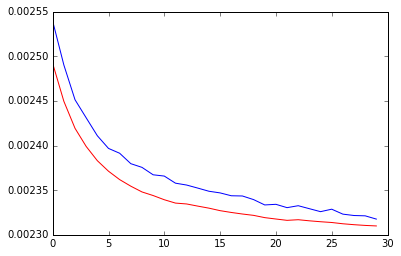

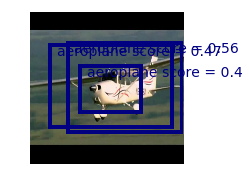

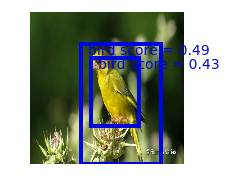

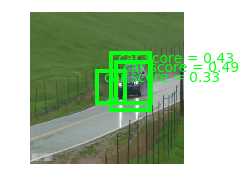

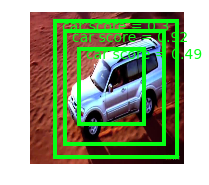

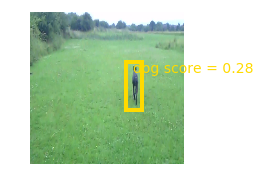

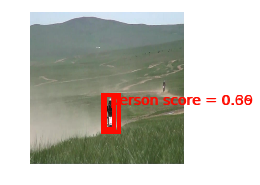

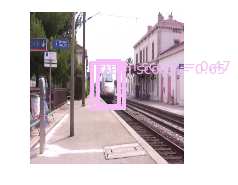

In [26]:
## actual training (fine-tuning)
import pdb
import time

num_epochs = 30
batch_size = 128
tr_indices  = np.array(range(len(training_list)))
vl_indices  = np.array(range(len(validation_list)))
tst_indices = np.array(range(len(test_list)))

# with open('YOLO_weights_YT.pkl', 'rb') as f:
#     net_YOLO_YT = pickle.load(f)

#prediction_var = T.fmatrix('predictions')
input_var = T.fmatrix('inputs')
target_var = T.fmatrix('targets')
weight_var = T.fmatrix('masks')

pred_var   = T.fmatrix('preds')

# pred_mat = np.zeros((batch_size, 1470), dtype='float32')
# prediction = theano.shared(np.asarray(pred_mat, dtype='float32'))

net_YOLO_YT = build_YT_net(net, input_var)
base_lr = 0.01
initial_factor = 1 #0.1  # initial_factor = 0.1 if nesterov ; 
learning_rate = base_lr * initial_factor #0.001  #0.001

#prediction = lasagne.layers.get_output(net_YOLO_YT['dense2'], inputs=input_var, deterministic = True) 
prediction = lasagne.layers.get_output(net_YOLO_YT['dense2'], inputs=input_var) 

loss = obj_det_loss(prediction, target_var)
loss = lasagne.objectives.aggregate(loss, weights = weight_var, mode='mean')  #mode='normalized_sum'

prediction_tst = lasagne.layers.get_output(net_YOLO_YT['dense2'], inputs=input_var, deterministic = True) 
loss_tst = obj_det_loss(prediction_tst, target_var)
loss_tst = lasagne.objectives.aggregate(loss_tst, weights = weight_var, mode='mean')  #mode='normalized_sum'

params   = lasagne.layers.get_all_params(net_YOLO_YT['dense2'], trainable=True)
#updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate = learning_rate, momentum=0.9)
updates = lasagne.updates.rmsprop(loss, params, learning_rate=learning_rate, rho=0.9, epsilon=1e-06)

train_fn = theano.function([input_var, target_var, weight_var], loss, updates = updates )
val_fn   = theano.function([input_var, target_var, weight_var], loss_tst)

pred_tr_fn  = theano.function([input_var], prediction)
pred_ts_fn  = theano.function([input_var], prediction_tst)

print("Starting training...")

train_error = []
val_error = []
    
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    
    #print("Running Epoch {} ".format(epoch + 1) )      
    if (epoch % 100 == 0) & (epoch != 0):
        learning_rate /= 10

        # As per YOLO paper
#     if( epoch >= 74 & epoch < 105):
#         learning_rate = base_lr * initial_factor * 0.1
#     elif (epoch >= 105):
#         learning_rate = base_lr * initial_factor * 0.01
        
    
    for batch in iterate_detection_minibatches(tr_indices, batch_size, shuffle = True):     
        #X_train_net_feats_mb = det_features(training_list, fl_to_featmap_index, batch)
        inputs = det_features_from_dense1(training_list, fl_to_featmap_index, batch)       
        targets = det_detection_truth(fl_to_featmap_index, training_list, batch)                 
        
        preds = pred_tr_fn(inputs)
        targets, masks   = create_compatible_label_masks_1(preds, targets, True) 
        #targets, masks   = create_compatible_label_masks(inputs, targets, True)  #False) # last param -> deterministic (with dropout) 
            
        train_err += train_fn(inputs, targets, masks)   #loss_mb = obj_det_loss(X_train_net_pred_mb, Y_train_mb)         
        train_batches += 1  #print 'after a mini-batch'
        
    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_detection_minibatches(vl_indices, batch_size, shuffle=False):
        inputs = det_features_from_dense1(validation_list, fl_to_featmap_index, batch)       
        targets = det_detection_truth(fl_to_featmap_index, validation_list, batch, False, True)        

        preds = pred_ts_fn(inputs)
        targets, masks   = create_compatible_label_masks_1(preds, targets, True) 
        #targets, masks   = create_compatible_label_masks(inputs, targets, True)      
        
        err       = val_fn(inputs, targets, masks)
        val_err += err
        val_batches += 1
        
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))    
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    
    train_error.append(train_err / train_batches)
    val_error.append(val_err / val_batches)
####################################  
      
### plot training and validation loss 
x = np.arange(0, num_epochs)
plt.plot(x, train_error, '-b', label='training_error')
plt.plot(x, val_error, '-r', label='validation_error')
  
# # After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
test_batch_size = 128
for batch in iterate_detection_minibatches(tst_indices, test_batch_size, shuffle=False):
    inputs = det_features_from_dense1(test_list, ts_fl_to_featmap_index, batch, False)       
    targets = det_detection_truth(ts_fl_to_featmap_index, test_list, batch, False, False) 
      
    preds = pred_ts_fn(inputs)
    
    targets, masks   = create_compatible_label_masks_1(preds, targets, True) 
    #targets, masks   = create_compatible_label_masks(inputs, targets, True) 
                               
    err       = val_fn(inputs, targets, masks) 
    #err = val_fn(inputs, targets, masks)
    test_err += err
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))


#pdb.set_trace()
#net_YOLO_YT = build_YT_net(net, input_var)

# #pdb.set_trace()
#######################################################
with open('X_test_dense1_feats.pkl', 'rb') as f:    
    X_feats = pickle.load(f)        
with open('Y_test_labels.pkl', 'rb') as f:    ## X_train_labels.pkl
    Y_labels = pickle.load(f)   #print Y_labels

###############################
colormap = plt.cm.gist_ncar
colors = [colormap(j) for j in np.linspace(0, 1, 20)]
draw_box_list = []
basic_path = 'Youtube/'
rand_test_num = [5, 300, 500, 800, 1147, 1500, 1740]
score_thresh = 0.25
##############################

net_YOLO_YT_FT = net_YOLO_YT
det_cases = np.zeros((20), dtype='int')
gt_cases = np.zeros((20), dtype='int')
inputs = np.zeros((1,4096), dtype = 'float32')
targets = np.zeros((1,1225), dtype='float32')
det_cases_all = np.zeros((1, 20), dtype='float32')
gt_cases_all  = np.zeros((1, 20), dtype='float32')

for l in range(0, len(test_list)):
    key_name = test_list[l]['GT_im_name']
    ft_idx = ts_fl_to_featmap_index[key_name] 
    inputs[0,:] = X_feats[ft_idx, :]
    targets[0,:] = Y_labels[ft_idx, :]
    det_cases, gt_cases = detect_accuracy(inputs, targets, net_YOLO_YT_FT) 
    
    det_cases_all = np.add(det_cases, det_cases_all)
    gt_cases_all  = np.add(gt_cases, gt_cases_all)
    
    if (l in rand_test_num):                      
        curr_num = test_list[l]['frame_num']       
        cat_name = test_list[l]['cat_type']
        
        file_name = basic_path + 'allImages/' + cat_name + '/' + curr_num + '.jpg'
        rawim, im = prep_image_from_name(file_name, 'jpg')  #             h, w, c = rawim.shape 
        h, w, c = rawim.shape
        
        pred = np.array(lasagne.layers.get_output(net_YOLO_YT_FT['dense2'], inputs, deterministic=True).eval()) 
 
        boxes, probs = convert_YOLO_det(np.transpose(pred), 20, 2, score_thresh, 7, 1, 0)
        draw_box_list = draw_detection_bbox(49*2, probs, boxes, 20, 2, w, h, score_thresh) 
                      
        plt.figure( )            
        plt.subplot(1,2,1)   
        plt.imshow(rawim.astype('uint8')) 

        for box in draw_box_list:
            x = box['left']
            y = box['top']
            w = box['right'] - box['left']
            h = box['bottom'] - box['top']
            category = box['category']
            confidence = float("{0:.2f}".format(box['confidence']))
            
            #print voc_name[category]

            plt.text(x+20, y+30, '{} score = {}'.format(voc_name[category], confidence), fontsize=14, color=colors[category])
            rect = plt.Rectangle((x,y), w, h, edgecolor=colors[category], facecolor="none", fill=False, linewidth = 4)
            plt.gca().add_patch(rect)
            plt.draw()
        plt.axis('off') 
    ####################################################################
    

print det_cases_all
print gt_cases_all
AP =  np.divide(det_cases_all, gt_cases_all) 
mAP = np.nansum(AP)/10
print AP*100
print mAP*100

#########################################################################

In [19]:
def build_FT_YT_net(net, net_YOLO_YT_FT, input_var = None):
    import lasagne
    from lasagne.layers import DropoutLayer
    from lasagne.layers import InputLayer
    from lasagne.layers import DenseLayer
    from lasagne.nonlinearities import LeakyRectify
    #from lasagne.layers import LocalResponseNormalization2DLayer as LRNLayer
    from lasagne.nonlinearities import softmax, linear
    
    my_net_YOLO_YT = net
    layer = net_YOLO_YT_FT['dense2']
    W = layer.W.get_value()
    b = layer.b.get_value()                            

    my_net_YOLO_YT['dense2'].W.set_value(W)  
    my_net_YOLO_YT['dense2'].b.set_value(b) 
    
    my_net_YOLO_YT['output']= my_net_YOLO_YT['dense2']
    
    return my_net_YOLO_YT

In [179]:
import pickle
net_YOLO_YT_FT = build_FT_YT_net(net, net_YOLO_YT_FT)
#print net_YOLO_YT_FT
with open('YOLO_FT_YT_weights_new.pkl', 'wb') as f:      
    pickle.dump(net_YOLO_YT_FT, f, -1)

[[ 151.    0.  149.  133.    0.    0.  455.   77.    0.  155.    0.   92.
   169.   63.    0.    0.    0.    0.  106.    0.]]
[[ 180.    0.  162.  222.    0.    0.  554.  165.    0.  273.    0.  172.
   395.  195.    0.    0.    0.    0.  158.    0.]]
[[ 83.88888889          nan  91.97530864  59.90990991          nan
           nan  82.1299639   46.66666667          nan  56.77655678
           nan  53.48837209  42.78481013  32.30769231          nan
           nan          nan          nan  67.08860759          nan]]
61.7016776905


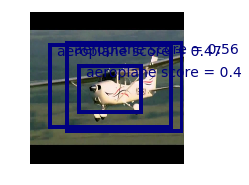

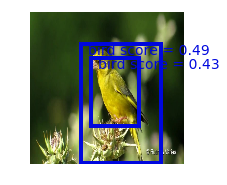

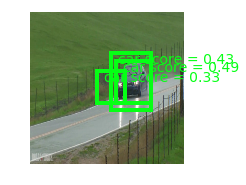

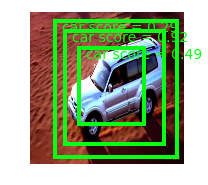

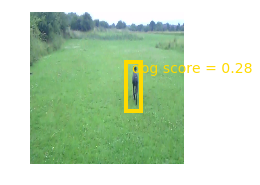

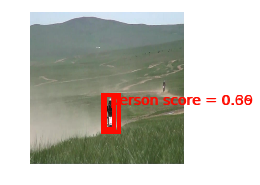

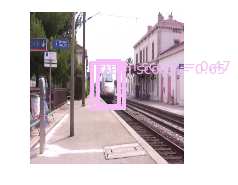

In [23]:
#######################################################
with open('X_test_dense1_feats.pkl', 'rb') as f:    
    X_feats = pickle.load(f)        
with open('Y_test_labels.pkl', 'rb') as f:    ## X_train_labels.pkl
    Y_labels = pickle.load(f)   #print Y_labels

###############################
colormap = plt.cm.gist_ncar
colors = [colormap(j) for j in np.linspace(0, 1, 20)]
draw_box_list = []
basic_path = 'Youtube/'
rand_test_num = [5, 300, 500, 800, 1147, 1500, 1740]
score_thresh = 0.25
##############################

net_YOLO_YT_FT = net_YOLO_YT
det_cases = np.zeros((20), dtype='int')
gt_cases = np.zeros((20), dtype='int')
inputs = np.zeros((1,4096), dtype = 'float32')
targets = np.zeros((1,1225), dtype='float32')
det_cases_all = np.zeros((1, 20), dtype='float32')
gt_cases_all  = np.zeros((1, 20), dtype='float32')

for l in range(0, len(test_list)):
    key_name = test_list[l]['GT_im_name']
    ft_idx = ts_fl_to_featmap_index[key_name] 
    inputs[0,:] = X_feats[ft_idx, :]
    targets[0,:] = Y_labels[ft_idx, :]
    det_cases, gt_cases = detect_accuracy(inputs, targets, net_YOLO_YT_FT) 
    
    det_cases_all = np.add(det_cases, det_cases_all)
    gt_cases_all  = np.add(gt_cases, gt_cases_all)
    
    if (l in rand_test_num):                      
        curr_num = test_list[l]['frame_num']       
        cat_name = test_list[l]['cat_type']
        
        file_name = basic_path + 'allImages/' + cat_name + '/' + curr_num + '.jpg'
        rawim, im = prep_image_from_name(file_name, 'jpg')  #             h, w, c = rawim.shape 
        h, w, c = rawim.shape        
        pred = np.array(lasagne.layers.get_output(net_YOLO_YT_FT['dense2'], inputs, deterministic=True).eval()) 
        boxes, probs = convert_YOLO_det(np.transpose(pred), 20, 2, score_thresh, 7, 1, 0)
        draw_box_list = draw_detection_bbox(49*2, probs, boxes, 20, 2, w, h, score_thresh) 
                      
        plt.figure( )            
        plt.imshow(rawim.astype('uint8')) 
        for box in draw_box_list:
            x = box['left']
            y = box['top']
            w = box['right'] - box['left']
            h = box['bottom'] - box['top']
            category = box['category']
            confidence = float("{0:.2f}".format(box['confidence']))
            
            #print voc_name[category]

            plt.text(x+20, y+30, '{} score = {}'.format(voc_name[category], confidence), fontsize=14, color=colors[category])
            rect = plt.Rectangle((x,y), w, h, edgecolor=colors[category], facecolor="none", fill=False, linewidth = 4)
            plt.gca().add_patch(rect)
            plt.draw()
        plt.axis('off') 
        

print det_cases_all
print gt_cases_all
AP =  np.divide(det_cases_all, gt_cases_all) 
mAP = np.nansum(AP)/10
print AP*100
print mAP*100

#########################################################################

In [29]:
# #### accuracy before and after fine-tuning
# import pdb
# import time

# input_var = T.fmatrix('inputs')
# target_var = T.fmatrix('targets')
# weight_var = T.fmatrix('masks')

# net_YOLO_YT = build_YT_net(net, input_var)
# prediction_tst = lasagne.layers.get_output(net_YOLO_YT['dense2'], deterministic = True) 
# loss_tst = obj_det_loss(prediction_tst, target_var)
# loss_tst = lasagne.objectives.aggregate(loss_tst, weights = weight_var, mode='mean')  #mode='normalized_sum'
# val_fn   = theano.function([input_var, target_var, weight_var], loss_tst)

# tst_indices = np.array(range(len(test_list)))
# test_error = []

# # ## debug : visualize random test cases
# # det_cases = np.zeros((20), dtype='int')
# # gt_cases = np.zeros((20), dtype='int')
# # basic_path = 'Youtube/allImages/'
# # random_im_idx = 190

# # with open('Y_test_labels.pkl', 'rb') as f:    ## X_train_labels.pkl
# #     try_Y_labels = pickle.load(f)   #print Y_labels 
# # with open('X_test_dense1_feats.pkl', 'rb') as f:   
# #     X_feats = pickle.load(f)
# # file_name = basic_path + test_list[random_im_idx]['cat_type'] + '/' + test_list[random_im_idx]['frame_num'] + '.jpg'                       
# # rawim, im = prep_image_from_name(file_name, 'jpg')
# # plt.figure()  
# # plt.imshow(rawim.astype('uint8'))   
# # t_inputs = np.array(lasagne.layers.get_output(net['dense1'], im, deterministic=True).eval())
# # inputs = np.zeros((1,4096), dtype = 'float32')
# # inputs[0,:] = t_inputs
# # key_name = test_list[random_im_idx]['GT_im_name']               
# # ft_idx = ts_fl_to_featmap_index[key_name]  
# # targets = np.zeros((1,1225), dtype='float32')
# # targets[0,:] = try_Y_labels[ft_idx, :] 
# # inputs = X_feats[ft_idx, :]
# # det_cases, gt_cases = detect_accuracy(inputs, targets, net_YOLO_YT) 
# # print gt_cases
# # print det_cases
# # prob = np.array(lasagne.layers.get_output(net_YOLO_YT['dense2'], inputs, deterministic=True).eval())
# # prob = np.transpose(prob)
# # boxes, probs = convert_YOLO_det(prob, 20, 2, 0.1, 7, 1, 0)
# # draw_box_list = draw_detection_bbox(49*2, probs, boxes, 20, 2, 448, 448, 0.14)               
# # for box in draw_box_list:
# #     x = box['left']
# #     y = box['top']
# #     w = box['right'] - box['left']
# #     h = box['bottom'] - box['top']
# #     category = box['category'] 
# #     confidence = float("{0:.2f}".format(box['confidence']))
# #     plt.text(x+20, y+30, '{} score = {}'.format(voc_name[category], confidence), fontsize=14, color=colors[category])
# #     rect = plt.Rectangle((x,y), w, h, edgecolor=colors[category], facecolor="none", fill=False, linewidth = 4)
# #     plt.gca().add_patch(rect)
# #     plt.draw()            
# #     plt.axis('off') 
# # pdb.set_trace()
# ####################################


# ####################################
# ### jugaD : before fine-tuning
# # net_YOLO_YT = build_YT_net(net, input_var)
# # with open('Y_test_labels.pkl', 'rb') as f:    ## X_train_labels.pkl
# #     try_Y_labels = pickle.load(f)   #print Y_labels 
# # with open('X_test_dense1_feats.pkl', 'rb') as f:   
# #     try_X_feats = pickle.load(f)
# # det_cases = np.zeros((20), dtype='int')
# # gt_cases = np.zeros((20), dtype='int')
# # inputs = np.zeros((1,4096), dtype = 'float32')
# # targets = np.zeros((1,1225), dtype='float32')
# # det_cases_all = np.zeros((1, 20), dtype='float32')
# # gt_cases_all  = np.zeros((1, 20), dtype='float32')
# # for l in range(0, len(test_list)):
# #     key_name = test_list[l]['GT_im_name']
# #     ft_idx = ts_fl_to_featmap_index[key_name] 
# #     inputs[0,:] = try_X_feats[ft_idx, :]
# #     targets[0,:] = try_Y_labels[ft_idx, :]
# #     det_cases, gt_cases = detect_accuracy(inputs, targets, net_YOLO_YT) 
    
# #     det_cases_all = np.add(det_cases, det_cases_all)
# #     gt_cases_all  = np.add(gt_cases, gt_cases_all)

# # print det_cases_all
# # print gt_cases_all
# # AP =  np.divide(det_cases_all, gt_cases_all) 
# # mAP = np.nansum(AP)/10
# # print AP*100
# # print mAP*100
# #pdb.set_trace()
# ###########


# ####################################
# ### jugaD : after fine-tuning
# # import pickle
# # with open('YOLO_weights_YT_FT.pkl', 'rb') as f:    
# #     net_YOLO_YT_FT = pickle.load(f) 
# det_cases = np.zeros((20), dtype='int')
# gt_cases = np.zeros((20), dtype='int')
# inputs = np.zeros((1,4096), dtype = 'float32')
# targets = np.zeros((1,1225), dtype='float32')
# det_cases_all = np.zeros((1, 20), dtype='float32')
# gt_cases_all  = np.zeros((1, 20), dtype='float32')
# for l in range(0, len(test_list)):
#     key_name = test_list[l]['GT_im_name']
#     ft_idx = ts_fl_to_featmap_index[key_name] 
#     inputs[0,:] = try_X_feats[ft_idx, :]
#     targets[0,:] = try_Y_labels[ft_idx, :]
#     det_cases, gt_cases = detect_accuracy(inputs, targets, net_YOLO_YT_FT) 
    
#     det_cases_all = np.add(det_cases, det_cases_all)
#     gt_cases_all  = np.add(gt_cases, gt_cases_all)

# print det_cases_all
# print gt_cases_all
# AP =  np.divide(det_cases_all, gt_cases_all) 
# mAP = np.nansum(AP)/10
# print AP*100
# print mAP*100
# pdb.set_trace()
# ###########

# # ### error in the beginning
# test_err = 0
# test_acc = 0
# test_batches = 0
# test_batch_size = 512

# det_cases_all = np.zeros((1, 20), dtype='int')
# gt_cases_all  = np.zeros((1, 20), dtype='int')
# for batch in iterate_detection_minibatches(tst_indices, test_batch_size, shuffle=False):    
#     inputs = det_features_from_dense1(test_list, ts_fl_to_featmap_index, batch)       
#     targets = det_detection_truth(ts_fl_to_featmap_index, test_list, batch, False, False) 
            
#     det_cases, gt_cases = detect_accuracy(inputs, targets, net_YOLO_YT)  
        
#     # mask generation
#     targets, masks   = create_compatible_label_masks(inputs, targets, True)   
#     err              = val_fn(inputs, targets, masks)
#     test_err += err
#     test_batches += 1
#     test_err += err
#     test_batches += 1
    
#     det_cases_all += det_cases
#     gt_cases_all  += gt_cases
    
# #     print det_cases
# #     print gt_cases
    
# test_error.append(test_err / test_batches)
# print("Initial results:")
# print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))

# print test_batches
# print det_cases_all
# print gt_cases_all

# pdb.set_trace()

# AP =  np.divide(det_cases_all, gt_cases_all) 
# mAP = np.sum(AP)/10
# print AP
# print mAP


# # # After training, we compute and print the test error:
# import pickle
# with open('YOLO_weights_YT_FT.pkl', 'rb') as f:    
#     net_YOLO_YT_FT = pickle.load(f) 

# prediction_tst = lasagne.layers.get_output(net_YOLO_YT_FT['dense2'], deterministic = True) 
# loss_tst = obj_det_loss(prediction_tst, target_var)
# loss_tst = lasagne.objectives.aggregate(loss_tst, weights = weight_var, mode='mean')  #mode='normalized_sum'
# val_fn   = theano.function([input_var, target_var, weight_var], loss_tst)    
       
# det_cases_all = np.zeros((1,20), dtype='int')
# gt_cases_all  = np.zeros((1,20), dtype='int')

# test_err = 0
# test_acc = 0
# test_batches = 0
# for batch in iterate_detection_minibatches(tst_indices, test_batch_size, shuffle=False):
#     inputs = det_features_from_dense1(test_list, ts_fl_to_featmap_index, batch)       
#     targets = det_detection_truth(ts_fl_to_featmap_index, test_list, batch, False, False) 

#     det_cases, gt_cases = detect_accuracy(inputs, targets, net_YOLO_YT_FT)
    
#     # mask generation
#     targets, masks   = create_compatible_label_masks(inputs, targets, True)  
#     err       = val_fn(inputs, targets, masks)
    
#     test_err += err
#     test_batches += 1
    
#     det_cases_all += det_cases
#     gt_cases_all  += gt_cases
    
# # AP =  np.divide(det_cases / gt_cases)  
# # mAP = np.mean(AP)
# # print AP
# # print mAP
    
# test_error.append(test_err / test_batches)

# print("Final results:")
# print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))

# print det_cases_all
# print gt_cases_all

# pdb.set_trace()

# AP =  np.divide(det_cases_all, gt_cases_all) 
# mAP = np.sum(AP)/10
# print AP
# print mAP



In [ ]:
# x = theano.shared(np.asarray([1, 2, 3], dtype='float32'))
# y = T.cast(x, 'float32')
# y.eval()

In [ ]:
# a = [5,1,7]
# print (np.argsort(a))
# print(np.argmax(a))
# print (np.argsort(a)[-1])

In [ ]:
# X_sym = T.tensor4()
# Y_sym = T.matrix()
# z_sym = T.vector()
# net_output    = lasagne.layers.get_output(net['output_layer'], X_sym)
# loss = obj_det_loss(net_output, Y_sym)
# params = lasagne.layers.get_all_params(net['output_layer'])
# grad = T.grad(loss, params)
# updates = lasagne.updates.sgd(grad, params, learning_rate=0.05)

In [ ]:
# def batch_gen(X, Y, N):
#     while True:
#         idx = np.random.choice(len(Y), N)
#         yield X[idx].astype('float32'), Y[idx].astype('float32')

In [ ]:
#for index, name in enumerate(layer_names): 
    #layer = net[name] 
    #shape = lasagne.layers.get_output_shape(layer, input_shapes=None)
        ##test = int(input("Proceed ?"))

#shape = lasagne.layers.get_output_shape(net['dense2'] , input_shapes=None)

In [28]:
# import skimage.transform
# import cv2
# import numpy as np

# import matplotlib.pyplot as plt

# %matplotlib inline


# import glob   
# path = '/home/subarna/my_code/YOLO_V/darknet/my_video_data/testJPEGImages/*.jpg'   
# files=glob.glob(path)

# ext = 'jpg'

# first = 1
# for name in files: 
#     print name
       
#     if (first == 1):
#         frame1 = plt.imread(name, ext)
#         prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
#         hsv = np.zeros_like(frame1)
#         hsv[...,1] = 255
#         first = 0        
#     else:
#         frame2 = plt.imread(name, ext)
#         next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

#         #flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
#         flow = cv2.calcOpticalFlowFarneback(prvs,next, 0.5, 3, 15, 3, 5, 1.2, 0)

#         mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
#         hsv[...,0] = ang*180/np.pi/2
#         hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
#         bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

#         #cv2.imshow('frame2',bgr)
        
#         k = int(input("Proceed ?"))

#         if k == 27:
#             break
#         else:
#             cv2.imwrite('of/opticalfb.png',frame2)
#             cv2.imwrite('of/opticalhsv.png',bgr)
#             prvs = next

            
# #cv2.destroyAllWindows()


# %pwd